# Studienarbeit: Uncertainty modelling of static laser scanning using Pointnet

##  Imports and settings

In [1]:
#Numerical, matrix operations
import numpy as np
import math

#Data read and write to make_dot
import os
import pandas as pd                                           #open source data analysis and manipulation tool
import csv

# Progress bars
from tqdm.notebook import tqdm

# Pytorch deep learning tensor manipulation framework
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
#from pointnet_utils import PointNetEncoder, feature_transform_reguliarzer
# Switch to CPU when GPU is not available.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from torchmetrics.regression import R2Score

# Draw pytorch's network
#from torchviz import make_dot

# Learning curve plotting
#from torch.utils.tensorboard import SummaryWriter

#Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.neighbors import KDTree
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
#Others
import seaborn as sns
import matplotlib.pyplot as plt
from plyfile import PlyData, PlyElement
import random
#import open3d as o3d
import copy

##   Part 1: Laden des Datensatzes & Zuordnen der Features

In [2]:
f = r"C:\Studienarbeit/Code/01_3DPrint.ply"
ply = PlyData.read(f)
x = ply.elements[0].data['x']
y = ply.elements[0].data['y']
z = ply.elements[0].data['z']
Scan_ID = ply.elements[0].data["scalar_Scan_ID"]
intensity = ply.elements[0].data['scalar_intensity']
incidence = ply.elements[0].data['scalar_incidence']
spotsize = ply.elements[0].data['scalar_spotsize']
sigma_dist = ply.elements[0].data['scalar_sigma_dist']
distance = ply.elements[0].data['scalar_range_measured']
range_residual = ply.elements[0].data['scalar_range_residual']

raw_f = np.c_[intensity,incidence,sigma_dist,distance]
raw_xyz = np.c_[x,y,z]
# Hier werdeb die Residuen auf 1 cm begrenzt. Alles was darüber liegt sind höchstwahrscheinlich Ausreißer
I = np.where(np.abs(range_residual < 0.01) & (incidence > 10))#&(sigma_dist<0.0007)

raw_f = raw_f[I[0],:]
xyz = raw_xyz[I[0],:]
raw_y = range_residual[I[0]]


### Feature Transformation

In [3]:
def pc_normalize(pc):
    '''normalize the point cloud by substracting the centroid and dividing by the maximum norm'''
    l = pc.shape[0]
    centroid = np.mean(pc, axis=0)
    pc = pc - centroid
    m = np.max(np.sqrt(np.sum(pc**2, axis=1)))
    pc = pc / m
    return pc

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
scaler = MinMaxScaler()
feature  = scaler.fit_transform(raw_f) # normalize
raw_fy =np.hstack((feature, raw_y.reshape(-1,1)))
xyz = pc_normalize(xyz)
scan_id = Scan_ID[I[0]]


##### read the file of group

In [4]:
import os

def ebene_loader(scan_id, data_path, filename_prefix): 
    '''load the point cloud of the plane'''
    filename_number = str(scan_id)
    file_path = os.path.join(data_path, f"{filename_prefix}_{filename_number}.npy")
    data = np.load(file_path)
    data = torch.from_numpy(data) 
    return data

def load_data(scan_ids, data_path, filename_prefix):
    raw_x_list = []
    for scan_idx in scan_ids:
        ebene_xyz = ebene_loader(scan_idx, data_path, filename_prefix)
        raw_x_list.append(ebene_xyz)
    raw_x = torch.cat(raw_x_list, dim=0)
    return raw_x

data_path = 'C:/Studienarbeit/Code/Pointnet/data/New/'
filename_prefix = "Group"
scan_ids = np.unique(scan_id)  # 假设scan_id已经定义
raw_x = load_data(scan_ids, data_path, filename_prefix)

#### Train datensatz & Test datensatz & Valid datensatz

In [5]:

x_rest, x_test, y_rest, y_test = train_test_split(raw_x, raw_fy,test_size=0.1,random_state=42)
#method 1 --------------------------------------------------------------------------------------
#x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=1) 

#method 2 KFold --------------------------------------------------------------------------------------
# from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
print(x_test.shape)
print("test data ratio:",round(y_test.shape[0]/raw_fy.shape[0]*100,2),"%")



torch.Size([253158, 128, 3])
test data ratio: 10.0 %


### Dataloader 
Read data from files and set up training, validation, and testing sets. 

In [6]:
class EbeneDataset(Dataset):  #Dataset
    '''
    x: np.ndarray  特征矩阵.
    y: np.ndarray  目标标签, 如果为None,则是预测的数据集
    '''
    def __init__(self, x, y=None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

In [7]:
def loader(x_train, y_train,x_valid, y_valid,x_test,y_test):
    
    train_dataset, valid_dataset, test_dataset = EbeneDataset(x_train, y_train),EbeneDataset(x_valid, y_valid),EbeneDataset(x_test,y_test)
    #print(train_dataset)

    # Pytoch data loader loads pytorch dataset into batchs./使用Pytorch中Dataloader类按照Batch将数据集加载
    #sheuffle: 每个 epoch 是否乱序
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    test_loader  = DataLoader(test_dataset , batch_size= 1, shuffle=False, pin_memory=True)

    return train_loader,valid_loader,test_loader

## Part 5: Deep learning Modellen 

### Transform & Transform reguliarze & PointNet

### Multi-scalegrouping $ Pointnet++
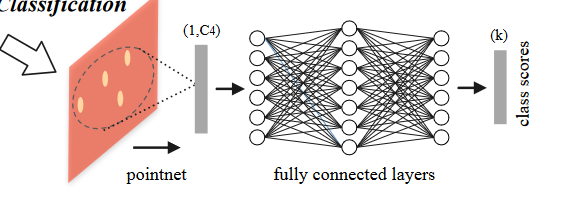

### Defining the PR_Model 

In [8]:

################
class RePN_Model(nn.Module): #Regression-PointNet
    def __init__(self,  nsample_list, mlp_list):
        super(RePN_Model, self).__init__()
        self.nsample_list = nsample_list
        self.mlp_list = mlp_list
        self.conv_blocks = nn.ModuleList() #ModuleList是一个储存各种模块的容器，可以像使用list一样使用它
        self.bn_blocks = nn.ModuleList()
        for i in range(len(mlp_list)):
            convs = nn.ModuleList()
            bns = nn.ModuleList()
            last_channel =  3
            for out_channel in mlp_list[i]:
                convs.append(nn.Conv1d(last_channel, out_channel, 1))
                bns.append(nn.BatchNorm1d(out_channel))
                last_channel = out_channel
            self.conv_blocks.append(convs)
            self.bn_blocks.append(bns)
        #print("self.conv_blocks:{}".format(self.conv_blocks))
        #print('self.bn_blocks:{}'.format(self.bn_blocks))
        self.fc1 = nn.Linear(324, 216) 
        self.fc2 = nn.Linear(216, 216)
        self.fc3 = nn.Linear(216, 110)
        self.fc4 = nn.Linear(110, 110)
        self.fc5 = nn.Linear(110, 1)
        self.noli = nn.ReLU()       #non-linearity


    def forward(self, x, f):
        xn = x.permute(0, 2, 1)  # [B, 3, K] 
        #print("x:{}".format(x))
        #print("x shape:{}".format(x.shape))
        new_points_list = []
        # Convolution input: [B, 3, K]  output: [B, 64/128/128, K]
        for i, nsample in enumerate(self.nsample_list):
            #print("i:{}".format(i))
            x = xn[:,:,:nsample]
            for j in range(len(self.conv_blocks[i])):
                #print("j:{}".format(j))
                conv = self.conv_blocks[i][j]
                #print("conv:{}".format(conv))
                bn = self.bn_blocks[i][j]
                #print("x shape:{}".format(x.shape))
                #grouped_points =  F.relu(bn(conv(x))) #卷积 B*3*K
                x = conv(x)
                x = bn(x)
                x = F.relu(x)

            new_points = torch.max(x, 2)[0]  # [B, 64/128/128] The first radius feature I*64 /The second radius feature I*128 /The third radius feature I*128
            new_points_list.append(new_points) #B*64 + B*128 + B*128    
        new_points_concat = torch.cat(new_points_list, dim=1)
        x = torch.cat([new_points_concat, f], dim=1) #B*(320+4) 
        # fully connected layer       
        x = self.fc1(x)
        x = self.noli(x)
        x = self.fc2(x)
        x = self.noli(x)
        x = self.fc3(x)
        x = self.noli(x)
        x = self.fc4(x)
        x = self.noli(x)
        x = self.fc5(x)

        return x




### Training loop

In [9]:
def trainer(train_loader, valid_loader, model, config, device):
    
    list_mean_train_loss = []
    list_mean_valid_loss = []

    criterion = nn.MSELoss() # loss function
    #criterion = nn.CrossEntropyLoss() # loss function
    
    # Define Optimizer
    #optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=0.9) #
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate']) #
    if not os.path.isdir('./models'):
        # Create folder - for storing models
        os.mkdir('./models')

    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0 #math.inf 无穷大

    for epoch in range(n_epochs):
        model.train() 
        loss_record = []
  
#train-----------------------------------------------------------------------------------------------------------
        # tqdm helps us to show the progress of our training  
        train_pbar = tqdm(train_loader, position=0, leave=True)      
        # Set the left side of the progress bar : Show the number of Epochs
        train_pbar.set_description(f'Epoch [{epoch+1}/{n_epochs}]')
        ss = 0
        for x, y in train_pbar:
 
            ss +=1
            f = y[:,:4]
            y = y[:,4]
            y = y.view(-1, 1)
            optimizer.zero_grad()               # Set the gradient to 0..
            x,  y, f = x.to(device), y.to(device),f.to(device)   # Transfer data one to the appropriate storage location (CPU/GPU)
            pred = model(x, f)      
            loss = criterion(pred, y)
            loss.backward()                     # Back propagation Calculation of gradients.
            optimizer.step()                    # Update network parameters
            step += 1
            loss_record.append(loss.detach().item())

            # After training a batch of data, show the loss on the right side of the progress bar
            #train_pbar.set_postfix({'loss': loss.detach().item()})
            if ss == 200:
               mean_train_loss = np.sqrt(np.mean(loss_record))*1000
               train_pbar.set_description('RMSE=: %f' % (mean_train_loss))
               ss = 0
               pass
            pass
        
        mean_train_loss = np.mean(loss_record)
        mean_train_loss = np.sqrt(mean_train_loss)*1000
        list_mean_train_loss.append(mean_train_loss)

#validation-------------------------------------------------------------------------------------------------------
        model.eval() # Set the model to evaluation mode.
        loss_record = []

        for x, y in valid_loader:
            f = y[:,:4]
            y = y[:,4].view(-1, 1)
            x, y, f = x.to(device), y.to(device), f.to(device)
            with torch.no_grad():
                pred = model(x, f)
                loss = criterion(pred, y)
            loss_record.append(loss.item())
            pass

        mean_valid_loss = np.mean(loss_record)
        mean_valid_loss = np.sqrt(mean_valid_loss)*1000
        list_mean_valid_loss.append(mean_valid_loss)
        print(f'Epoch [{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss:.12f},\
        Valid loss: {mean_valid_loss:.12f}')

#------------------------------------------------------------------------------------------------------------------ 
        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            torch.save(model.state_dict(), config['save_path'][k]) # Model Saving
            print('Saving model with loss {:.12f}...'.format(best_loss))
            early_stop_count = 0
        else: 
            early_stop_count += 1

        if early_stop_count >= config['early_stop']:
            print('\nModel is not improving, so we halt the training session.')
            return list_mean_train_loss, list_mean_valid_loss
        pass
    return list_mean_train_loss, list_mean_valid_loss , best_loss


### Start training

In [10]:
def print_summary( list_mean_train_loss, list_mean_valid_los):
 
    plt.subplot(1,2,2)
    plt.plot([x for x in list_mean_train_loss], label='Training Loss')
    plt.plot([x for x in list_mean_valid_los], label='Validation Loss')
    plt.legend()
    plt.show()

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    pass

In [11]:
a = [1,2,3]
b = [4,5,6]
c = [[1,2,3],[4,5,6]]   
c= list(np.mean(c,axis=0))
print(c)

[2.5, 3.5, 4.5]


  0%|          | 0/56961 [00:00<?, ?it/s]

Epoch [1/15]: Train loss: 0.742396476956,        Valid loss: 0.460562238280
Saving model with loss 0.460562238280...


  0%|          | 0/56961 [00:00<?, ?it/s]

Epoch [2/15]: Train loss: 0.460856146573,        Valid loss: 0.481927545297


  0%|          | 0/56961 [00:00<?, ?it/s]

Epoch [3/15]: Train loss: 0.442019681809,        Valid loss: 0.395425873822
Saving model with loss 0.395425873822...


  0%|          | 0/56961 [00:00<?, ?it/s]

Epoch [4/15]: Train loss: 0.431708085599,        Valid loss: 0.643752957683


  0%|          | 0/56961 [00:00<?, ?it/s]

Epoch [5/15]: Train loss: 0.424047241023,        Valid loss: 0.463720630346


  0%|          | 0/56961 [00:00<?, ?it/s]

Epoch [6/15]: Train loss: 0.419361023737,        Valid loss: 0.372684673910
Saving model with loss 0.372684673910...


  0%|          | 0/56961 [00:00<?, ?it/s]

Epoch [7/15]: Train loss: 0.409368477522,        Valid loss: 0.401466688865


  0%|          | 0/56961 [00:00<?, ?it/s]

Epoch [8/15]: Train loss: 0.410312295582,        Valid loss: 0.360753861733
Saving model with loss 0.360753861733...


  0%|          | 0/56961 [00:00<?, ?it/s]

Epoch [9/15]: Train loss: 0.401108403946,        Valid loss: 0.388838754615


  0%|          | 0/56961 [00:00<?, ?it/s]

Epoch [10/15]: Train loss: 0.398233926112,        Valid loss: 0.446737988364


  0%|          | 0/56961 [00:00<?, ?it/s]

Epoch [11/15]: Train loss: 0.399723940441,        Valid loss: 0.408006484698


  0%|          | 0/56961 [00:00<?, ?it/s]

Epoch [12/15]: Train loss: 0.392907437380,        Valid loss: 0.469207992926


  0%|          | 0/56961 [00:00<?, ?it/s]

Epoch [13/15]: Train loss: 0.391560049339,        Valid loss: 0.365862018203


  0%|          | 0/56961 [00:00<?, ?it/s]

Epoch [14/15]: Train loss: 0.387885116414,        Valid loss: 0.371268166409


  0%|          | 0/56961 [00:00<?, ?it/s]

Epoch [15/15]: Train loss: 0.390013238479,        Valid loss: 0.355474494510
Saving model with loss 0.355474494510...
list_mean_train_loss:[0.742396476956452, 0.4608561465727729, 0.442019681809214, 0.43170808559909696, 0.4240472410227823, 0.4193610237374037, 0.40936847752234856, 0.41031229558206184, 0.40110840394607694, 0.3982339261115776, 0.39972394044083603, 0.39290743737991485, 0.3915600493390999, 0.3878851164144447, 0.3900132384788288]
list_mean_valid_loss:[0.4605622382795165, 0.4819275452967781, 0.39542587382234357, 0.6437529576831863, 0.4637206303460515, 0.3726846739098003, 0.40146668886469633, 0.3607538617333235, 0.38883875461479867, 0.4467379883642647, 0.4080064846984756, 0.46920799292648124, 0.36586201820250996, 0.37126816640854954, 0.35547449451027563]


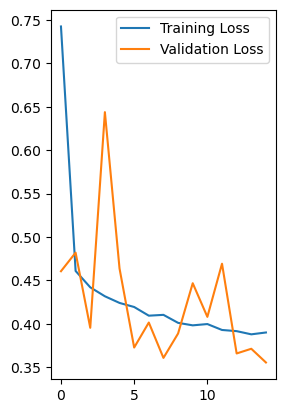

  0%|          | 0/56961 [00:00<?, ?it/s]

Epoch [1/15]: Train loss: 0.384835289492,        Valid loss: 0.381034223108
Saving model with loss 0.381034223108...


  0%|          | 0/56961 [00:00<?, ?it/s]

Epoch [2/15]: Train loss: 0.383652607033,        Valid loss: 0.393126830411


  0%|          | 0/56961 [00:00<?, ?it/s]

Epoch [3/15]: Train loss: 0.384634877264,        Valid loss: 0.495828796861


  0%|          | 0/56961 [00:00<?, ?it/s]

Epoch [4/15]: Train loss: 0.382731175455,        Valid loss: 0.358491887077
Saving model with loss 0.358491887077...


  0%|          | 0/56961 [00:00<?, ?it/s]

Epoch [5/15]: Train loss: 0.380912818447,        Valid loss: 0.396627703528


  0%|          | 0/56961 [00:00<?, ?it/s]

Epoch [6/15]: Train loss: 0.380998431798,        Valid loss: 0.349940614842
Saving model with loss 0.349940614842...


  0%|          | 0/56961 [00:00<?, ?it/s]

Epoch [7/15]: Train loss: 0.378858027010,        Valid loss: 0.379303906059


  0%|          | 0/56961 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [12]:


config = {
    'seed': 9,
    'n_epochs': 15,     # Number of epoche(Interation)           
    'batch_size': 32, 
    'learning_rate': 0.001,              
    'early_stop': 15,    # If model has not improved for this many consecutive epoche, stop training/如果early_stop轮损失没有下降就停止训练.     
    'save_path': ['./models/model1.ckpt','./models/model2.ckpt','./models/model3.ckpt','./models/model4.ckpt','./models/model5.ckpt'],  # Model will be saved here.
}
setup_seed(config['seed'])
#model = Re_Model(input_dim=324,normal_channel=False).to(device) # 将模型和训练数据放在相同的存储位置(CPU/GPU)
model = RePN_Model( [16, 32, 128], [[32, 32, 64], [64, 64, 128], [64, 96, 128]]).to(device) # 将模型和训练数据放在相同的存储位置(CPU/GPU)
#k = 0
list_train = []
list_valid = [] 
for k, (train_index, valid_index) in enumerate(kf.split(x_rest)):
    model =  copy.deepcopy(model)
    x_train, x_valid = x_rest[train_index], x_rest[valid_index]
    y_train, y_valid = y_rest[train_index], y_rest[valid_index]
    train_loader,valid_loader,test_loader = loader(x_train, y_train,x_valid, y_valid, x_test, y_test)
    #training
    list_mean_train_loss, list_mean_valid_loss = trainer(train_loader, valid_loader, model, config, device)
    print('list_mean_train_loss:{}'.format(list_mean_train_loss))
    print('list_mean_valid_loss:{}'.format(list_mean_valid_loss))
    print_summary( list_mean_train_loss, list_mean_valid_loss)
    list_train.append(list_mean_train_loss)
    list_valid.append(list_mean_valid_loss)
    #k += 1
    #test
    pass
list_train = list(np.mean(list_train,axis=0))
list_valid = list(np.mean(list_valid,axis=0))
print('list_train:{}'.format(list_train))
print('list_valid:{}'.format(list_valid))
print_summary( list_train, list_valid)
    





### Test

In [ ]:

def predict(test_loader, model, device):
    model.eval() # 设置成eval模式.
    preds = []
    f = torch.tensor(y_test[:,:4])
    for x, y in tqdm(test_loader):
  
        f = y[:,:4]
        #print(f.shape)
        x = x.to(device)                        
        with torch.no_grad():
            pred = model(x, f)         
            preds.append(pred.detach().cpu())   
    preds = torch.cat(preds, dim=0).numpy()

    # x = test_loader
    # #x = x.to(device) 
    # with torch.no_grad():
    #     pred = model(x)         
    #     preds.append(pred.detach().cpu())    
    return preds

def save_pred(preds, file):
    ''' 将模型保存到指定位置'''
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])
list_pred = []
for i in range(5):
    config['save_path'] = './models/model{}.ckpt'.format(i+1)
    model.load_state_dict(torch.load(config['save_path']))
    preds = predict(test_loader, model, device) 
    list_pred.append(preds) 
preds = np.mean(list_pred, axis=0)

save_pred(preds, 'pred.csv')
y_test = torch.tensor(y_test[:,4])
RMSE = np.sqrt(mean_squared_error(y_test, preds))
R2 = r2_score(y_test, preds)
print(f"  R2 = {R2*100:.2f} , RMSE = {RMSE:.6f}") 

  0%|          | 0/253158 [00:00<?, ?it/s]

  R2 = 71.66 , RMSE = 0.000340


|   Interation |hidden layer|  batchsize |learning_rate| RMSE|R2score  |
|  ----  | ----  |----  |----  |----  |----  |
| 20  |2|64|0.001| 0.3468|70.39 |
| 2  | 2 |64|0.001|0.4268||
| 2  | 4 |64|0.001|0.4074||
| 20  | 4 |64|0.001|0.3361|71.66|
| 20  | 2 |64|0.0001|0.498||


In [ ]:
22